#Generative models
In this Lab we will be experimenting with

- Convolutional autoencoders
- Latent space visualization and interpolation
- Upsampling techniques
- Variational autoencoders
- Deep Convolutional GANs (DCGANs)

If you want to experiment with Denoising Autoencoders, revisit Lab 3 (task 5):
https://github.com/klaverhenrik/Deep-Learing-for-Visual-Recognition-2023/blob/main/Lab3_FunWithMNIST.ipynb

**Before you start, remember to set runtime to GPU**

**NOTE:** In case you have trouble running Keras/TensorFlow in Colab, try one of the following:

##1. Download the MNIST dataset
As usual:

In [1]:
from __future__ import print_function
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Pre-process inputs
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class indices to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
# Input shape: 28 x 28 x 1 = image with one color channel
print('input_shape :',input_shape)

# Pre-process inputs
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# to_categorical converts class indices to one-hot vectors
print('y_train shape:', y_train.shape)

input_shape : (28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)


##2. Task 1: Convolutional Autoencoder
Recall that *generative models* try to learn something useful about the distribution of the data. A succesful generative model is one that allows us to draw realistically looking samples from the original distribution.

In today's lab, we will be using MNIST, but we will assume that we don't know the labels and see if we can detect interesting structures in the data - without using the labels. Hence, all the generative models below represent examples of *unsupervised learning*.

The simplest type of generative model is an *autoencoder* (AEs). Traditional AEs are fully connected (i.e., inputs and outputs are vectors), which we know is not very useful when dealing with image data. Therefore, we will be using the convolutional variant, called a Convolutional Autoencoder (CAE).

There are many ways to implement CAEs. The one below is designed to map the input data down to a 2D *latent space*, so that you can plot the latent vectors in 2D. In this way we can use to CAE to visualize the distribution of our data in 2D.

**Note** that below we define the encoder and the decoder separately and combine them afterwards to form the final CAE model.


###2.1 Your task
An autoencoder learns an identity function, meaning that we require the input and output of the model to have exactly the same shape.

Your task is to specify the kernel size and padding size of the last layer, such that shape of the decoder's output matches the input shape (28x28x1). That is, fill in the missing code marked with `???`:

```
decoded = Conv2D(1, kernel_size=???, padding=???, activation='sigmoid')(x)
```

Recall that in Keras, padding can be set to either `same` or `valid` (what's the difference?).

In [3]:
from keras.layers import Input, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import UpSampling2D, ZeroPadding2D, Conv2DTranspose, Reshape

# Number of latent dimensions
latent_dim = 2

# Encoder (convolutional base)
inputs = Input(shape=(28, 28, 1))
x = ZeroPadding2D(padding=(2, 2))(inputs)
x = Conv2D(8, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(16, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

x = Flatten()(x) # vectorize last feature map
encoded = Dense(latent_dim)(x) # map to vector of length "latent_dim"
encoder = Model(inputs, encoded)
encoder.summary()
print(("shape of encoded", K.int_shape(encoded)))

# Decoder (upsamling)
encoding = Input(shape=(latent_dim))
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(encoding)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(x)
decoded = Conv2D(1, kernel_size=(5,5), padding='valid', activation='sigmoid')(x) # Fix this line !!!
decoder = Model(encoding, decoded)
decoder.summary()
print(("shape of decoded", K.int_shape(decoded)))

x = encoder(inputs)
predictions = decoder(x)
autoencoder = Model(inputs, predictions)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 32, 32, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                             

###Solution

In [4]:
from keras.layers import Input, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import UpSampling2D, ZeroPadding2D, Conv2DTranspose, Reshape

# Number of latent dimensions
latent_dim = 2

# Encoder (convolutional base)
inputs = Input(shape=(28, 28, 1))
x = ZeroPadding2D(padding=(2, 2))(inputs)
x = Conv2D(8, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(16, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)
print("shape of x", shape)

x = Flatten()(x) # vectorize last feature map
encoded = Dense(latent_dim)(x) # map to vector of length "latent_dim"
encoder = Model(inputs, encoded)
encoder.summary()
print(("shape of encoded", K.int_shape(encoded)))

# Decoder (upsamling)
encoding = Input(shape=(latent_dim))
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(encoding)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(x)
decoded = Conv2D(1, kernel_size=(5, 5), padding='valid', activation='sigmoid')(x)
decoder = Model(encoding, decoded)
decoder.summary()
print(("shape of decoded", K.int_shape(decoded)))

x = encoder(inputs)
predictions = decoder(x)
autoencoder = Model(inputs, predictions)

shape of x (None, 4, 4, 32)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 32, 32, 1)         0         
 ing2D)                                                          
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                               

###2.2 Questions:
1. What does the `ZeroPadding2D` layer do?
2. What is the shape of the data before and after zero padding? (Note: for downsampling and upsampling it is more convenient if the shape of the data is a power of 2).
3. What is the purpose of the `Reshape`layer in the decoder?


###Answers
1. It extends the size of the input image by two pixels on all sides from 28x28x1 to 32x32x1.
2. Before 28x28x1 and after 32x32x1. We prefer 32 over 28 because it is a power of 2 (during downsampling and upsampling the shapes are easily calculated as 32->16->8->4->8->16->32).
3. The input to the decoder is a 2-dimensional vector (you can change that by setting `latent_dim`), which is transformed to a 512 dimensional vector through a dense (fully connected) layer. This shape comes from the last feature map of the encoder, which is a 4x4x32 = 512. The purpose of the Reshape layer is to convert the 512-D vector into a a 4x4x32 volume, matching the shape of the last feature map of the encoder (and thereby making the encoder/decoder symmetric).

###2.3 Training
Let's train the autoencoder for 30 epochs (add more epochs to improve results):

In [5]:
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(x_train, x_train, epochs=30, batch_size=256,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

Epoch 1/30
235/235 [==============================] - 19s 11ms/step - loss: 0.0818 - val_loss: 0.0574
Epoch 2/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0557 - val_loss: 0.0543
Epoch 3/30
235/235 [==============================] - 2s 7ms/step - loss: 0.0531 - val_loss: 0.0519
Epoch 4/30
235/235 [==============================] - 2s 7ms/step - loss: 0.0510 - val_loss: 0.0497
Epoch 5/30
235/235 [==============================] - 2s 7ms/step - loss: 0.0492 - val_loss: 0.0486
Epoch 6/30
235/235 [==============================] - 2s 7ms/step - loss: 0.0480 - val_loss: 0.0475
Epoch 7/30
235/235 [==============================] - 2s 7ms/step - loss: 0.0472 - val_loss: 0.0467
Epoch 8/30
235/235 [==============================] - 2s 8ms/step - loss: 0.0467 - val_loss: 0.0462
Epoch 9/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0463 - val_loss: 0.0460
Epoch 10/30
235/235 [==============================] - 2s 7ms/step - loss: 0.0459 - val_loss: 0.04

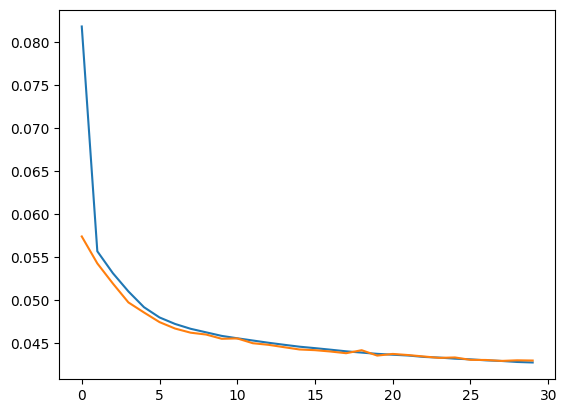

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

###2.4 Plot the latent space representation
To get some intuition about what our autoencoder has learned, we can plot the latent representation of the training data:

1875/1875 [==============================] - 3s 2ms/step


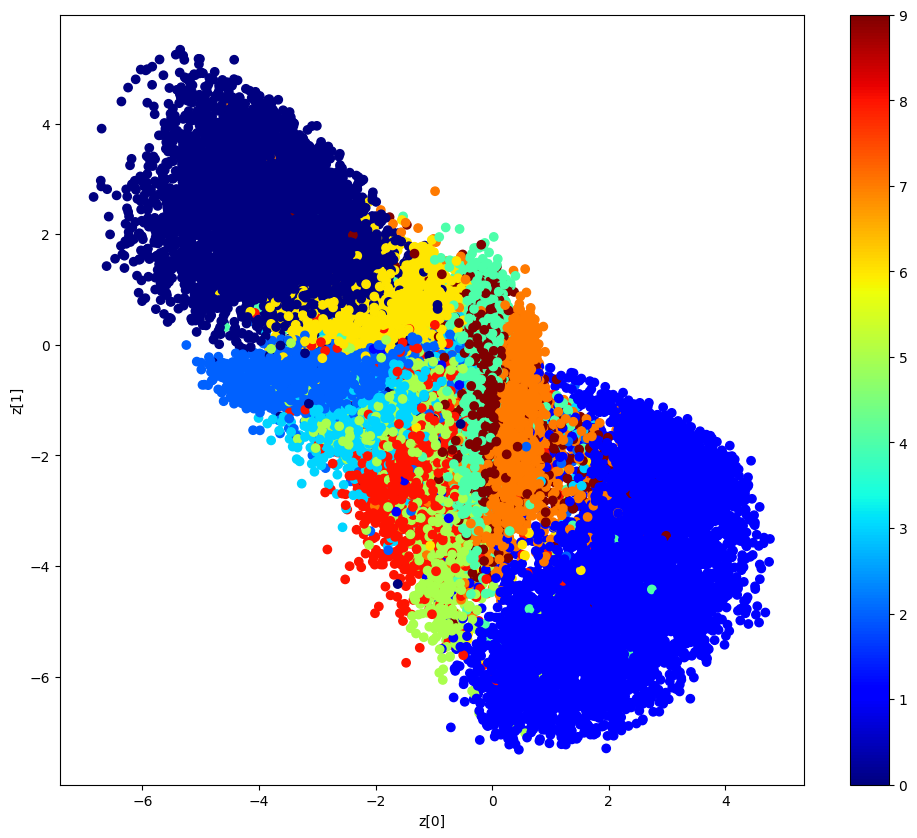

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='jet')

# Get latent representation
z = encoder.predict(x_train,batch_size=32)

# Plot
plt.figure(figsize=(12, 10))
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(y_train,axis=1))
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

Each color represents a different class. What do you see from this plot? Which classes are clearly separated, and which are mixed up?

Recall that training was *unsupervised*, i.e., it was performed without knowing the labels. The autoencoder is a generative model, so we are also interested in seing **how well it is able to draw samples from the data distribution** it has learned. To do that we will use the autoencoder to *generate* new samples. We do this by generating latent vectors that span a 2D grid (defined by `grid_x` and `grid_y` below) and then feed each latent vector on the grid into the decoder to generate an image:

**Note** you will have to adjust the limits of `grid_x` and `grid_y` to match the range of latent features that your model has learned.

1/1 [==============================] - 0s 16ms/step


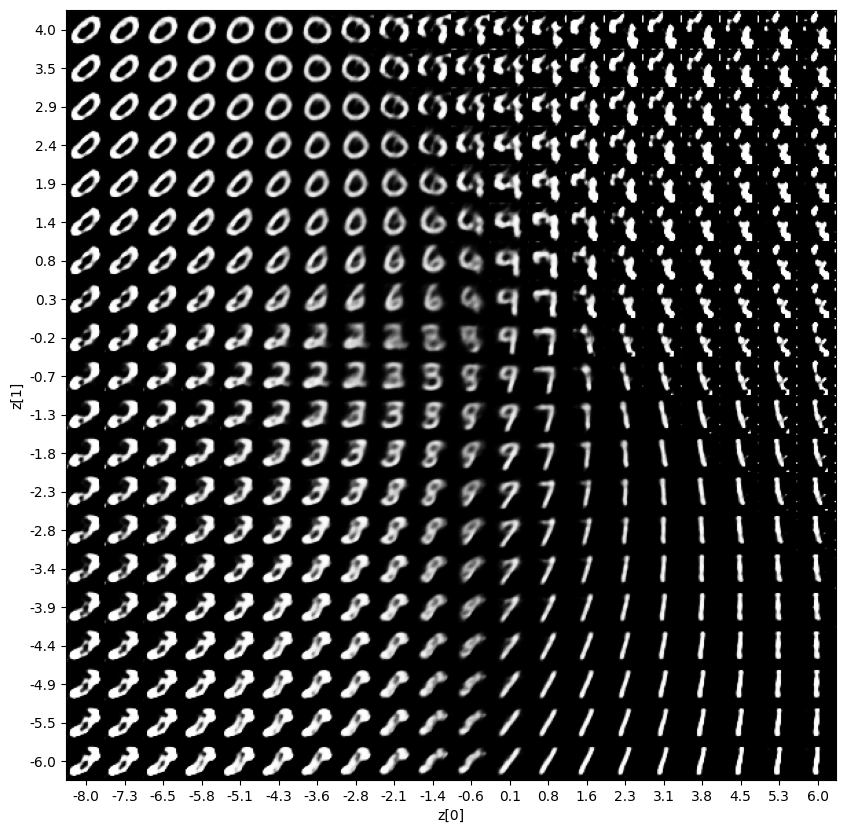

In [8]:
import numpy as np
import matplotlib.pyplot as plt

n = 20 # number of grid cells
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-8, 6, n)        # Task : Set range according to your latent representation
grid_y = np.linspace(-6, 4, n)[::-1]  # Task : Set range according to your latent representation

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample.reshape(1,2))
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
pixel_range = np.linspace(digit_size/2,n*digit_size-digit_size/2,n)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')

The grid above shows the "digits" generated by the autoencoder for different combinations of 2D latent vectors (corresponding to the values on the x- and y-axis).

###2.5 Question
1. Which digits can the autoencoder generate faithfully, which digits does it have trouble generating? Could we explain why?

###Answer
1. May digits are squashed together at the center of the latent space, so these cannot be faithfully reconstructed. The ones that are nicely separated (and can be reconstructed) are 0 and 1, andto some extend 2, 6, 7, and 9.

###2.6 Encoding, decoding and latent space interpolation
Now that we have trained an autoencoder, we can use it to encode existing images and generate new images (from a latent representation). With the latent representation we can also start doing interpolation between training samples.

Your task is to

1. Encode an image of a 7 and an image of a 9 (or any other pair if you refer)
2. Decode the encodings to generate reconstructed images
3. Interpolate between the two digits in latent space

You just need to figure out what the missing shapes `???` should be.

Original input images


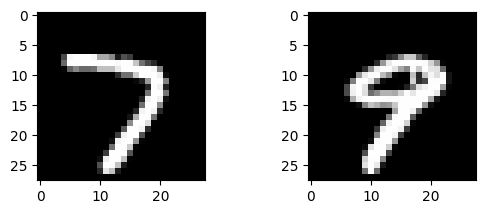

1/1 [==============================] - 0s 27ms/step
Images reconstructewd from 2D latens representation


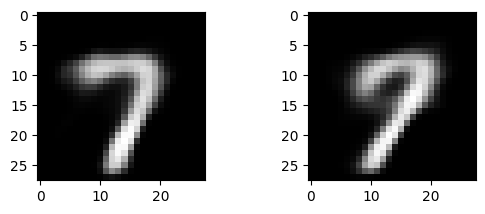

Interpolated images
1/1 [==============================] - 0s 26ms/step


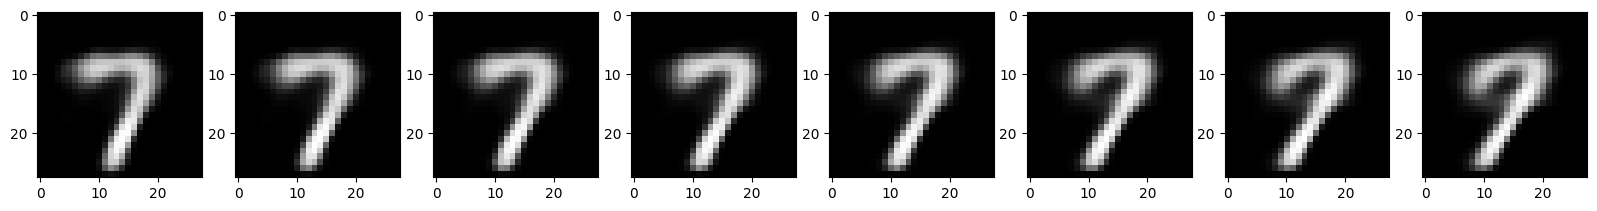

In [9]:
# Draw two samples (a 7 and a 9) and display them
y_test_category = np.argmax(y_test,axis=1)
ix7 = np.where(y_test_category==7)[0][1] # Pick a 7
ix9 = np.where(y_test_category==9)[0][1] # Pick a 9

print('Original input images')
plt.subplot(221);plt.imshow(x_test[ix7,:].squeeze(),cmap='gray')
plt.subplot(222);plt.imshow(x_test[ix9,:].squeeze(),cmap='gray')
plt.show()

# Subtask 1 (encoding):
# Calculate the latent representation of each sample using the encoder
z7 = encoder.predict(x_test[ix7,:].reshape(1,28,28,1))
z9 = encoder.predict(x_test[ix9,:].reshape(1,28,28,1))

# Subtask 2 (decoding):
# Reconstruct images from the two latent vectors using the decoder
x_hat_7 = decoder.predict(z7.reshape(1,latent_dim))
x_hat_9 = decoder.predict(z9.reshape(1,latent_dim))

# Show reconstruction
print('Images reconstructewd from 2D latens representation')
plt.subplot(223);plt.imshow(x_hat_7.squeeze(),cmap='gray')
plt.subplot(224);plt.imshow(x_hat_9.squeeze(),cmap='gray')
plt.show()

# Subtask 3 (interpolate):
# Just run - no changes required)
N = 8
interp_features = np.zeros((N,latent_dim))
for i in range(latent_dim):
  interp_features[:,i] = np.linspace(z7[0,i].squeeze(),z9[0,i].squeeze(),N)

print('Interpolated images')
plt.figure(figsize=(20,6))
for i in range(N):
  x = interp_features[i,:].reshape(1,latent_dim)
  out = decoder.predict(x)
  plt.subplot(1,N,i+1)
  plt.imshow(out.squeeze(),cmap='gray')

###Solution

Original input images


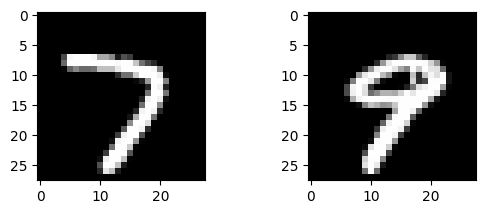

1/1 [==============================] - 0s 15ms/step
Images reconstructewd from 2D latent representation


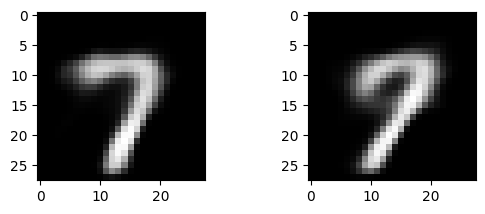

Interpolated images
1/1 [==============================] - 0s 19ms/step


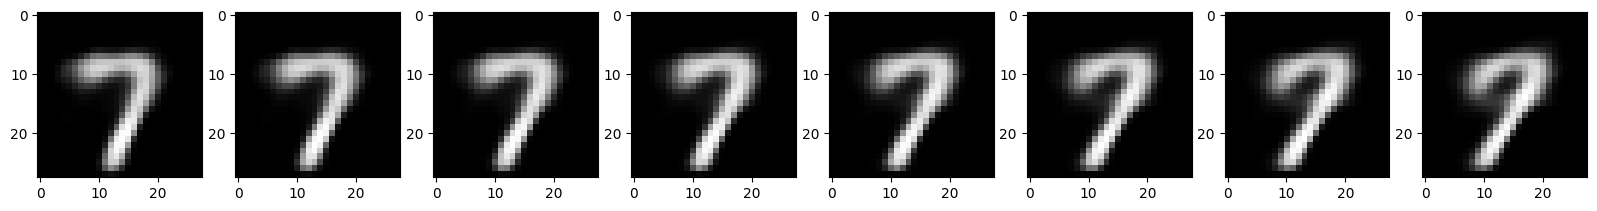

In [10]:
# Draw two samples (a 7 and a 9)
y_test_category = np.argmax(y_test,axis=1)
ix7 = np.where(y_test_category==7)[0][1]
ix9 = np.where(y_test_category==9)[0][1]

print('Original input images')
plt.subplot(221);plt.imshow(x_test[ix7,:].squeeze(),cmap='gray')
plt.subplot(222);plt.imshow(x_test[ix9,:].squeeze(),cmap='gray')
plt.show()

# Encoding: Calculate the latent representation of each sample
z7 = encoder.predict(x_test[ix7,:].reshape(1,28,28,1))
z9 = encoder.predict(x_test[ix9,:].reshape(1,28,28,1))

# Decoding: Reconstruct images from the two latent vectors
x_hat_7 = decoder.predict(z7.reshape(1,latent_dim))
x_hat_9 = decoder.predict(z9.reshape(1,latent_dim))

# Show reconstruction
print('Images reconstructewd from 2D latent representation')
plt.subplot(223);plt.imshow(x_hat_7.squeeze(),cmap='gray')
plt.subplot(224);plt.imshow(x_hat_9.squeeze(),cmap='gray')
plt.show()

N = 8
interp_features = np.zeros((N,latent_dim))
for i in range(latent_dim):
  interp_features[:,i] = np.linspace(z7[0,i].squeeze(),z9[0,i].squeeze(),N)

print('Interpolated images')
plt.figure(figsize=(20,6))
for i in range(N):
  x = interp_features[i,:].reshape(1,latent_dim)
  out = decoder.predict(x)
  plt.subplot(1,N,i+1)
  plt.imshow(out.squeeze(),cmap='gray')

**Perspectives:** Given a dataset of facial images, you could use latent space interpolation to generate images like these:

![alt text](https://github.com/davidsandberg/facenet/wiki/20170708-150701-add_smile.png)

##3. Task 2: Implement a CAE from scratch
The purpose of this task is to test if you can implement a CAE from scratch. **I recommend you skip ahead and complete the tasks on variational encoders and GANs first, and then return to this task later**.

Your task is to implement this CAE archtecture for MNIST:

![alt text](https://github.com/aivclab/dlcourse/raw/master/data/Lab9_CAE_architecture.png)

**Explanation**:
- "Conv 1", "Conv 2", "Conv 3", "D Conv 1", "D Conv 2", "D Conv 3", and "D Conv 4" are *all* regular 2D convolutions: [Conv2D](https://keras.io/layers/convolutional/#conv2d).
- "M.P" is short for Max Pooling
- "U.S" is short for upsampling. You must use [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) and **not** [Conv2DTranspose](https://keras.io/keras_core/api/layers/convolution_layers/convolution2d_transpose/). (What's the difference by the way?)

###Solution

In [11]:
# Encoder (convolutional base)
inputs = Input(shape=(28, 28, 1))
x = Conv2D(16, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(8, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(8, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(x)
latent = MaxPooling2D(pool_size=(2,2),padding='same')(x)

# Decoder (upsamling)
x = Conv2D(8, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(latent)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(8, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(16, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid')(x)
x = UpSampling2D(size=(2,2))(x)
decoded = Conv2D(1, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='same')(x)
print(("shape of decoded", K.int_shape(decoded)))

autoencoder = Model(inputs, decoded)
autoencoder.summary()

('shape of decoded', (None, 28, 28, 1))
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)

##4. Task 3: Variational Autoencoder
Recall that variational autoencoders (VAE) are designed to learn smooth latent space representation. The problem with traditional autoencoders is that they tend to generate gaps in the latent space, making interpolation impossible. The purpose of this task is to see if this is actually the case in practise.

Below is an implementation of a convolutional VAE.

In [12]:
from keras.layers import UpSampling2D, ZeroPadding2D, Conv2DTranspose, Lambda, Reshape

batch_size = 256
latent_dim = 2

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(28, 28, 1),name='encoder_input')
x = ZeroPadding2D(padding=(2, 2))(inputs)
x = Conv2D(8, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(16, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Use reparameterization trick to push the sampling out as input.
# Note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(64, (1,1), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(x)
outputs = Conv2D(1, kernel_size=(5, 5), padding='valid', activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 32, 32, 1)            0         ['encoder_input[0][0]']       
 ing2D)                                                                                           
                                                                                                  
 conv2d_15 (Conv2D)          (None, 16, 16, 8)            80        ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv2d_16 (Conv2D)          (None, 8, 8, 16)             1168      ['conv2d_15[0][0]']     

###4.1 Questions
1. What do you think the `sampling` function does?
2. The encoder outputs three variables: `[z_mean, z_log_var, z]`. What do you think they represent?

###Answers
1. The encoder of the VAE generates two vectors, `z_mean` and `z_log_var`, which correspond to the parameters of a Gaussian distribution. The first parameter is the mean, and the second parameter is the logarithm of the variance. The sampling layer simply draws samples from this distribution, which are returned in the tensor `z`. Note that the exponential `K.exp(z_log_sigma)` cancels out the logarithm, such that `K.exp(z_log_sigma)` returns the variance.
2. See answer 1.

###4.2 Loss function
The loss consists of two terms:

- A reconstruction term (or similarity term)
- and a KL divergence term

You can read more about it here: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

The KL term is:

![alt text](https://miro.medium.com/max/520/1*uEAxCmyVKxzZOJG6afkCCg.png)

**Sub-task:** See if you can identify the individual terms in the code block below.

In [13]:
from keras.losses import mse
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= 28 * 28
kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var/2 - 1
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  61572     ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (256, 2)]                                                           
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            29385     ['encoder[0][2]']             
                                                                                                

###Answers:
`reconstruction_loss` measures the similarity between the input image and the output image, measured as the mean squared error (or the L2 norm).

`kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var - 1` is the KL term with
- `K.exp(z_log_var)` = variance
- `K.square(z_mean)` = mean value squared
- `z_log_var` = log of the variance

Note that in my solution, I changed

`kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var - 1`

to

`kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var/2 - 1`

because `z_log_var` should be the log of the standard deviation (sigma) and not the log of the variance (sigma squared). To fix this, we use the relationship:

`log(x^2) = 2 * log(x) or equivalently log(x) = log(x^2)/2`

`kl_loss *= 0.5` determines the weight of the KL term relative to the reconstruction term.



###4.3 Training

In [14]:
num_samples = int(np.floor(x_train.shape[0] / batch_size) * batch_size)
vae.fit(x_train[0:num_samples,:], epochs=30, batch_size=batch_size,
        shuffle=True, verbose=1)

Epoch 1/30
234/234 [==============================] - 6s 8ms/step - loss: 56.5191
Epoch 2/30
234/234 [==============================] - 3s 11ms/step - loss: 44.4590
Epoch 3/30
234/234 [==============================] - 3s 11ms/step - loss: 41.4870
Epoch 4/30
234/234 [==============================] - 2s 8ms/step - loss: 40.2175
Epoch 5/30
234/234 [==============================] - 2s 8ms/step - loss: 39.3688
Epoch 6/30
234/234 [==============================] - 2s 7ms/step - loss: 38.6452
Epoch 7/30
234/234 [==============================] - 2s 7ms/step - loss: 38.0537
Epoch 8/30
234/234 [==============================] - 2s 9ms/step - loss: 37.5235
Epoch 9/30
234/234 [==============================] - 2s 9ms/step - loss: 37.0721
Epoch 10/30
234/234 [==============================] - 2s 8ms/step - loss: 36.6752
Epoch 11/30
234/234 [==============================] - 2s 7ms/step - loss: 36.3082
Epoch 12/30
234/234 [==============================] - 2s 8ms/step - loss: 36.0100
Epoch 13/30

###4.4 Plot the latent space representation

234/234 [==============================] - 1s 2ms/step


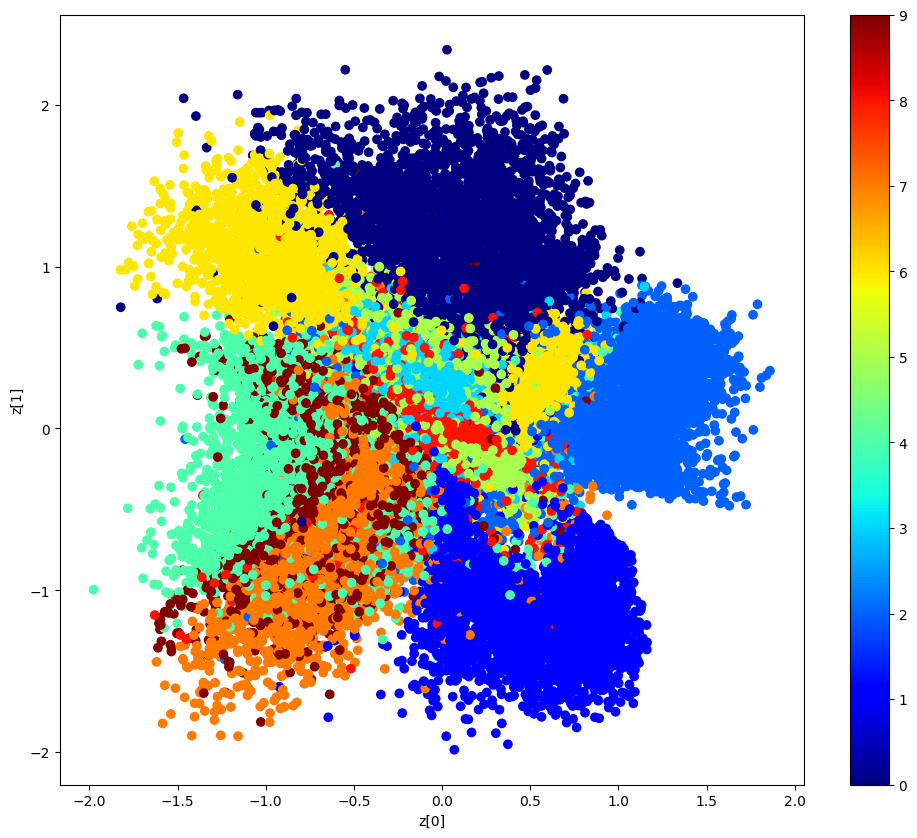

In [15]:
z_mean, _, _ = encoder.predict(x_train[0:num_samples,:],
                                batch_size=batch_size)
import matplotlib as mpl
mpl.rc('image', cmap='jet')
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=np.argmax(y_train[0:num_samples,:],axis=1))
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

1/1 [==============================] - 0s 18ms/step


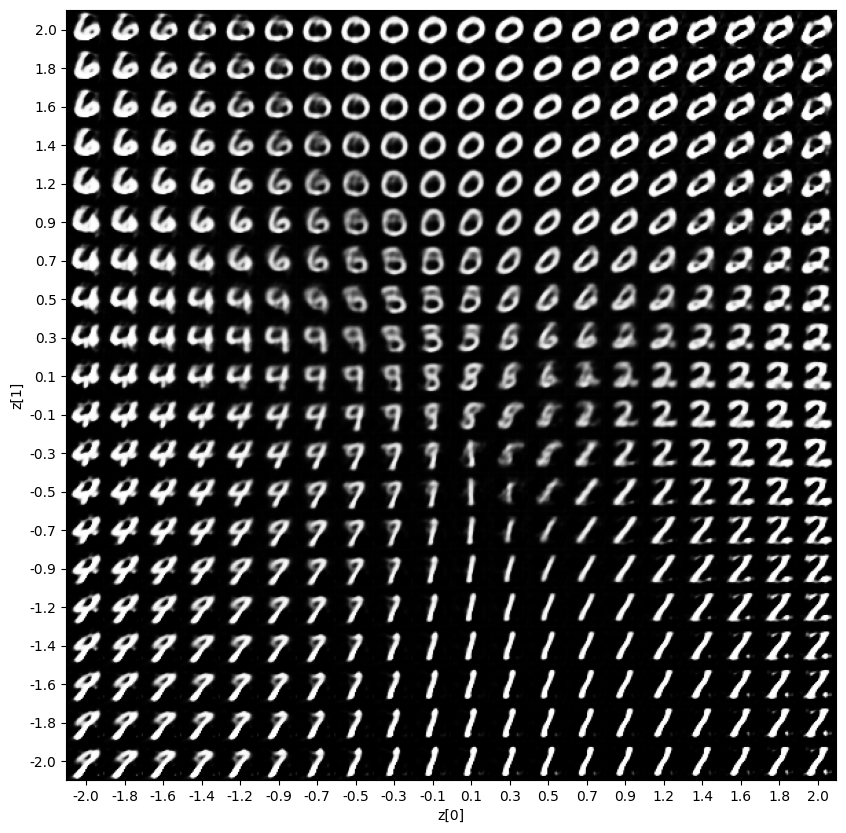

In [16]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
pixel_range = np.linspace(digit_size/2,n*digit_size-digit_size/2,n)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')

###4.5 Questions
1. What do you think of this latent representation? In terms of quality? In terms of smoothness? Compare to the same plot for the traditional convolutional autoencoder.
2. Which digits does the model faithfully reconstruct? Which digits does it have trouble reconstructing? Why?
3. What happens if you set the weight of the KL term to, say 5 (`kl_loss *= 5`), and re-train the model?

###Answers
1. It looks less elongated than the representation obtained with the traditional autoencoder, i.e., the data is more evenly distributed around 0. It looks fairly smooth too. However, the class separation is not mproved.
2. The VAE reconstructs 0 and 1 well, like the traditional AE. In addition, it faithfully reconstructs 6 and 7, and to some extent 2 and 9.
3. The classes will not be separated (try it yourself). The reason is that the KL loss dominates the learning process, so the model will just try to learn a latent representation that looks like a 2D Gaussian, *without* considering that the latent vectors should also be useful for decoding/reconstructing realistic digits (the reconstruction term of the loss function).

###4.6 Encoding, decoding and latent space interpolation
Like we did for the traditional conovolutional autoencoder (see section 2.6), your task is to

1. Encode an image of a 7 and an image of a 9.
2. Decode the encodings (to generate reconstructed images)
3. Interpolate between the two digits in latent space

The challenge here is that the encoder expects a fixed batch size (of 256 in our case). So you cannot just input one image to the model. The solution is to first process the training data set in batches of 256, and store the encodings:

In [17]:
# Get 2D encoding of all test examples (in batches of 100 images)
num_samples = int(np.floor(x_test.shape[0] / batch_size) * batch_size)
z_test = np.zeros((num_samples,latent_dim))
num_batches = int(num_samples / batch_size)
for i in range(num_batches):
  batch = x_test[i*batch_size:(i+1)*batch_size,:,:,:]
  [z_m, z_lv, z_val] = encoder.predict(batch,batch_size=batch_size)
  z_test[i*batch_size:(i+1)*batch_size,:] = z_m

1/1 [==============================] - 0s 22ms/step


Original input images


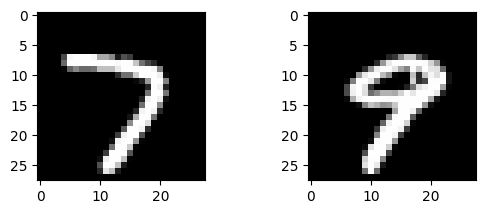

1/1 [==============================] - 0s 16ms/step


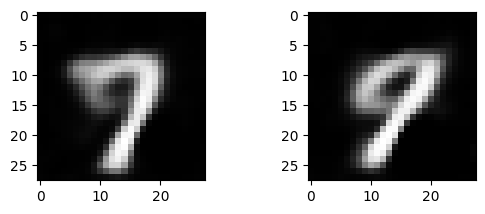

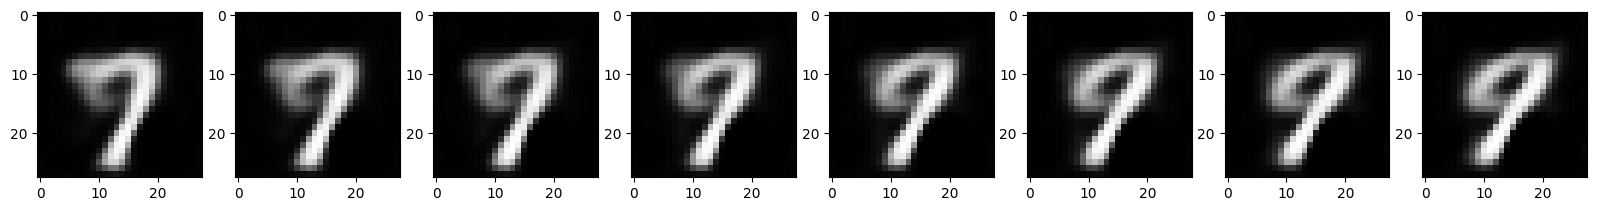

In [18]:
# Draw two samples (a 7 and a 9)
y_test_category = np.argmax(y_test,axis=1)
ix7 = np.where(y_test_category==7)[0][1]
ix9 = np.where(y_test_category==9)[0][1]

print('Original input images')
plt.subplot(221);plt.imshow(x_test[ix7,:].squeeze(),cmap='gray')
plt.subplot(222);plt.imshow(x_test[ix9,:].squeeze(),cmap='gray')
plt.show()

# Subtask 1 (encoding): Calculate the latent representation of each sample
z7 = z_test[ix7,:]
z9 = z_test[ix9,:]

# Subtask 2 (decoding): Reconstruct images from the two latent vectors
x_hat_7 = decoder.predict(z7.reshape(1,latent_dim))
x_hat_9 = decoder.predict(z9.reshape(1,latent_dim))

# Show reconstruction
plt.subplot(223);plt.imshow(x_hat_7.squeeze(),cmap='gray')
plt.subplot(224);plt.imshow(x_hat_9.squeeze(),cmap='gray')

N = 8
interp_features = np.zeros((N,latent_dim))
for i in range(latent_dim):
  interp_features[:,i] = np.linspace(z7[i].squeeze(),z9[i].squeeze(),N)

plt.figure(figsize=(20,6))
for i in range(N):
  x = interp_features[i,:].reshape(1,latent_dim)
  out = decoder.predict(x)
  plt.subplot(1,N,i+1)
  plt.imshow(out.squeeze(),cmap='gray')

### Solution

Original input images


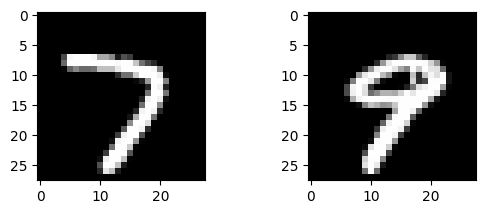

1/1 [==============================] - 0s 32ms/step


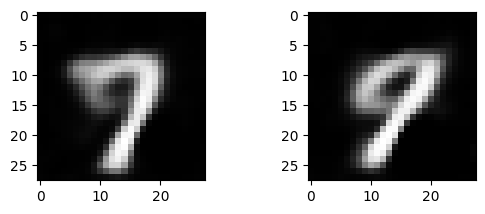

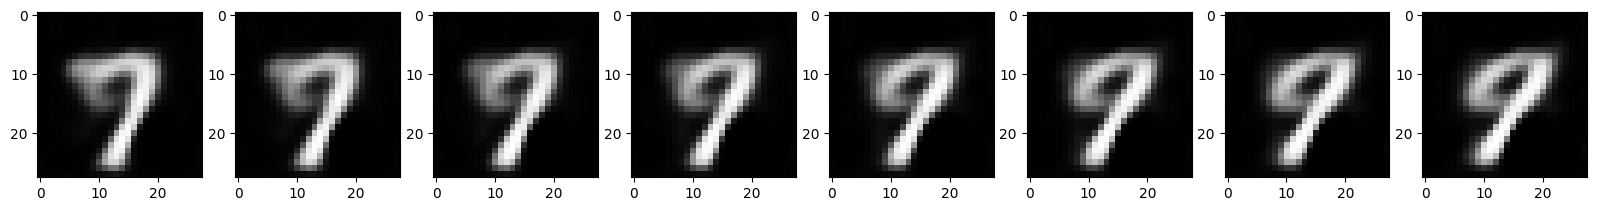

In [19]:
# Draw two samples (a 7 and a 9)
y_test_category = np.argmax(y_test,axis=1)
ix7 = np.where(y_test_category==7)[0][1]
ix9 = np.where(y_test_category==9)[0][1]

print('Original input images')
plt.subplot(221);plt.imshow(x_test[ix7,:].squeeze(),cmap='gray')
plt.subplot(222);plt.imshow(x_test[ix9,:].squeeze(),cmap='gray')
plt.show()

# Subtask 1 (encoding): Calculate the latent representation of each sample
z7 = z_test[ix7,:]
z9 = z_test[ix9,:]

# Subtask 2 (decoding): Reconstruct images from the two latent vectors
x_hat_7 = decoder.predict(z7.reshape(1,latent_dim))
x_hat_9 = decoder.predict(z9.reshape(1,latent_dim))

# Show reconstruction
plt.subplot(223);plt.imshow(x_hat_7.squeeze(),cmap='gray')
plt.subplot(224);plt.imshow(x_hat_9.squeeze(),cmap='gray')

N = 8
interp_features = np.zeros((N,latent_dim))
for i in range(latent_dim):
  interp_features[:,i] = np.linspace(z7[i].squeeze(),z9[i].squeeze(),N)

plt.figure(figsize=(20,6))
for i in range(N):
  x = interp_features[i,:].reshape(1,latent_dim)
  out = decoder.predict(x)
  plt.subplot(1,N,i+1)
  plt.imshow(out.squeeze(),cmap='gray')

**Note:** If you want to make nicer reconstructions and better interpolations, increase the latent dimensionality (latent_dim) and re-train the model.

##5. Task 4: Generative Adversarial Networks
Last year's version of this task was based on [this tutorial](https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py). Its an implementation of a Deep Convolutional GAN (DCGAN) for MNIST.

Unfortunately that doesn't work anymore and I haven't been able to figure out why. Therefore, I advice you to go through this tutorial instead: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb

You can load it as a notebook in Colab using [this link](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb)

###5.1 Recommended tasks (advanced and not mandatory)
1. See if you can figure out how to decrease the dimensionality of the latent space from 100 to 2? Then retrain the model.

2. Extend the code such that you can train the model to learn a 2D latent representation of MNIST and subsequently make it generate images based on some 2D latent vector that you specify. Use this to make a plot of the 2D latent space, like we did above. What do you observe?

###5.2 Conditional GANs (not mandatory)
The original GAN has no knowledge, and hence no understanding of the data's class labels. This implies that if you tell a traditional GAN to generate an image of a digit, the GAN will most likely generate a realistically looking digit, but it will have absolutely no clue about which digit it is.

Conditional GANs (CGANs) aim to solve this issue by telling both the generator and the discriminator what the class label is. Specifically, CGAN concatenates a one-hot vector y to the random noise vector z to result in an architecture that looks like this, where `y` is a one-encoding of the class label.

![alt text](https://paper-attachments.dropbox.com/s_D85DDA7D01FD04AEE96825C4B90F1126BC7D080CA4F2947D4A5DEC07FAD6122C_1559840765144_Screenshot+2019-06-06+at+10.35.29+PM.png)

If you have more time, you could try out the CGAN tutorial:

- https://keras.io/examples/generative/conditional_gan/
- Colab link: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/conditional_gan.ipynb

How does it work?


